In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-for-assignment/data.csv


In [ ]:
# Install all required libraries
!pip install -q pandas beautifulsoup4 scikit-learn nltk textstat sentence-transformers requests joblib
print("All libraries installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 6.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━

In [ ]:
# Data Collection & HTML Parsing
import pandas as pd
from bs4 import BeautifulSoup
import os
import re

print("--- Phase 1: Data Collection & HTML Parsing ---")

# Define Kaggle Paths 
# Input path from the Kaggle dataset you added
INPUT_CSV = '/kaggle/input/dataset-for-assignment/data.csv' 

# Output files will be saved in /kaggle/working/
# We create 'data' and 'models' folders inside /kaggle/working/
DATA_DIR = '/kaggle/working/data'
MODELS_DIR = '/kaggle/working/models'
OUTPUT_CSV = os.path.join(DATA_DIR, 'extracted_content.csv')

# Create output directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
print(f"Output directories created at {DATA_DIR} and {MODELS_DIR}")

# Load Dataset 
if not os.path.exists(INPUT_CSV):
    print(f"Error: Input file not found at {INPUT_CSV}")
    print("Please check the 'Add data' panel on the right. Is the dataset added?")
else:
    print(f"Loading dataset from {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    print(f"Loaded {len(df)} rows.")

    # HTML Parsing Function 
    def parse_html_content(html_content):
        """
        Parses raw HTML to extract title and clean body text.
        Handles errors gracefully.
        """
        if pd.isna(html_content) or not html_content.strip():
            return "No Title", "No Content", 0

        try:
            soup = BeautifulSoup(html_content, 'html.parser')

            # Extract Title
            title = soup.title.string if soup.title else 'No Title Found'

            # Extract Body Text: Focus on common content tags
            content_tags = soup.find('article') or soup.find('main') or soup.find_all('p')
            
            if content_tags:
                if isinstance(content_tags, list): # From find_all('p')
                    body_text = ' '.join([tag.get_text(separator=' ') for tag in content_tags])
                else: # From find('article') or find('main')
                    body_text = content_tags.get_text(separator=' ')
            else:
                body_text = soup.body.get_text(separator=' ') if soup.body else ''

            # Clean the text: remove extra whitespace
            body_text = re.sub(r'\s+', ' ', body_text).strip()
            word_count = len(body_text.split())

            return title, body_text, word_count

        except Exception as e:
            # Handle any parsing errors
            return "Parsing Error", f"Error: {e}", 0

    # Apply Parsing and Save 
    print("Parsing HTML content for all rows... This may take a moment.")
    
    parsed_data = df['html_content'].apply(lambda x: pd.Series(parse_html_content(x)))
    parsed_data.columns = ['title', 'body_text', 'word_count']
    
    # Combine with original URL
    df_extracted = pd.concat([df[['url']], parsed_data], axis=1)
    
    # Drop rows where parsing failed or yielded no content
    df_extracted = df_extracted[df_extracted['word_count'] > 0]

    # Save Output 
    df_extracted.to_csv(OUTPUT_CSV, index=False)
    
    print(f"\nSuccessfully parsed {len(df_extracted)} pages.")
    print(f"Saved extracted content to {OUTPUT_CSV}")
    print("\nExample Output:")
    print(df_extracted.head())
    print("\n--- Phase 1 Complete ---")

--- Phase 1: Data Collection & HTML Parsing ---
Output directories created at /kaggle/working/data and /kaggle/working/models
Loading dataset from /kaggle/input/dataset-for-assignment/data.csv...
Loaded 81 rows.
Parsing HTML content for all rows... This may take a moment.

Successfully parsed 69 pages.
Saved extracted content to /kaggle/working/data/extracted_content.csv

Example Output:
                                                 url  \
0     https://www.cm-alliance.com/cybersecurity-blog   
1    https://www.varonis.com/blog/cybersecurity-tips   
2  https://www.cisecurity.org/insights/blog/11-cy...   
3  https://www.cisa.gov/topics/cybersecurity-best...   
5  https://nordlayer.com/learn/network-security/b...   

                                               title  \
0                                Cyber Security Blog   
1  Top 10 Cybersecurity Awareness Tips: How to St...   
2  11 Cyber Defense Tips to Stay Secure at Work a...   
3  Cybersecurity Best Practices | Cybersecurity 

In [ ]:
# Text Preprocessing & Feature Engineering
import pandas as pd
import os
import nltk
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np

print("\n--- Phase 2: Text Preprocessing & Feature Engineering ---")

# Setup and Load Data 
# Download NLTK data
nltk.download('punkt', quiet=True) 

# Define paths
DATA_DIR = '/kaggle/working/data'
EXTRACTED_CSV = os.path.join(DATA_DIR, 'extracted_content.csv')
FEATURES_CSV = os.path.join(DATA_DIR, 'features.csv')
EMBEDDINGS_FILE = os.path.join(DATA_DIR, 'embeddings.npy') # Save embeddings separately

if not os.path.exists(EXTRACTED_CSV):
    print(f"Error: File not found at {EXTRACTED_CSV}. Please run Phase 1 first.")
else:
    print(f"Loading extracted content from {EXTRACTED_CSV}...")
    df_features = pd.read_csv(EXTRACTED_CSV)
    df_features = df_features.dropna(subset=['body_text'])

    # Clean Text
    df_features['clean_text'] = df_features['body_text'].str.lower()
    print("Text cleaned (lowercased).")

    # Extract Basic & Readability Features 
    print("Calculating readability and sentence counts...")
    df_features['sentence_count'] = df_features['clean_text'].apply(lambda x: len(nltk.sent_tokenize(str(x))))
    df_features['flesch_reading_ease'] = df_features['clean_text'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
    
    # Extract TF-IDF Keywords
    print("Calculating TF-IDF keywords...")
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_features['clean_text'])
    
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    def get_top_keywords(row, top_n=5):
        scores = row.toarray().flatten()
        top_indices = scores.argsort()[-top_n:][::-1]
        return '|'.join(feature_names[top_indices])

    df_features['top_keywords'] = [get_top_keywords(row) for row in tfidf_matrix]
    print("Top 5 keywords extracted.")

    # Generate Embeddings (This will use your T4 GPU!) 
    print("Generating sentence embeddings... This will use the GPU and should be fast.")
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2') 
    
    embeddings = sbert_model.encode(df_features['clean_text'].tolist(), show_progress_bar=True)
    print(f"Embeddings generated with shape: {embeddings.shape}")
    
    # Save Features and Embeddings
    # Don't save embeddings in the CSV (it's inefficient)
    features_to_save = df_features.drop(columns=['body_text', 'clean_text'])
    features_to_save.to_csv(FEATURES_CSV, index=False)
    
    # Save embeddings to a separate .npy file
    np.save(EMBEDDINGS_FILE, embeddings)
    
    print(f"Features saved to {FEATURES_CSV}")
    print(f"Embeddings saved to {EMBEDDINGS_FILE}")
    print("\nExample Features Output:")
    print(features_to_save.head())
    print("\n--- Phase 2 Complete ---")


--- Phase 2: Text Preprocessing & Feature Engineering ---
Loading extracted content from /kaggle/working/data/extracted_content.csv...
Text cleaned (lowercased).
Calculating readability and sentence counts...
Calculating TF-IDF keywords...
Top 5 keywords extracted.
Generating sentence embeddings... This will use the GPU and should be fast.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embeddings generated with shape: (69, 384)
Features saved to /kaggle/working/data/features.csv
Embeddings saved to /kaggle/working/data/embeddings.npy

Example Features Output:
                                                 url  \
0     https://www.cm-alliance.com/cybersecurity-blog   
1    https://www.varonis.com/blog/cybersecurity-tips   
2  https://www.cisecurity.org/insights/blog/11-cy...   
3  https://www.cisa.gov/topics/cybersecurity-best...   
4  https://nordlayer.com/learn/network-security/b...   

                                               title  word_count  \
0                                Cyber Security Blog         326   
1  Top 10 Cybersecurity Awareness Tips: How to St...        1700   
2  11 Cyber Defense Tips to Stay Secure at Work a...        1058   
3  Cybersecurity Best Practices | Cybersecurity a...         826   
4     Network Security 101: Understanding the Basics        2188   

   sentence_count  flesch_reading_ease  \
0               6            -6.816

In [ ]:
# Duplicate Detection
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity

print("\n--- Phase 3: Duplicate Detection ---")

# Load Data 
DATA_DIR = '/kaggle/working/data'
FEATURES_CSV = os.path.join(DATA_DIR, 'features.csv')
EMBEDDINGS_FILE = os.path.join(DATA_DIR, 'embeddings.npy')
DUPLICATES_CSV = os.path.join(DATA_DIR, 'duplicates.csv')

if not (os.path.exists(FEATURES_CSV) and os.path.exists(EMBEDDINGS_FILE)):
    print("Error: Files from Phase 2 not found. Please run Phase 2 first.")
else:
    print("Loading features and embeddings...")
    df_features = pd.read_csv(FEATURES_CSV)
    embeddings = np.load(EMBEDDINGS_FILE)

    # Compute Cosine Similarity 
    print("Computing cosine similarity matrix...")
    sim_matrix = cosine_similarity(embeddings)
    
    # Identify Duplicate Pairs
    SIMILARITY_THRESHOLD = 0.80 
    duplicate_pairs = []
    
    # Iterate over the upper triangle of the matrix
    for i in range(len(sim_matrix)):
        for j in range(i + 1, len(sim_matrix)):
            if sim_matrix[i, j] > SIMILARITY_THRESHOLD:
                pair = {
                    'url1': df_features.iloc[i]['url'],
                    'url2': df_features.iloc[j]['url'],
                    'similarity': sim_matrix[i, j]
                }
                duplicate_pairs.append(pair)
    
    # Save Duplicate Pairs 
    df_duplicates = pd.DataFrame(duplicate_pairs)
    df_duplicates = df_duplicates.sort_values(by='similarity', ascending=False)
    df_duplicates.to_csv(DUPLICATES_CSV, index=False)

    if not df_duplicates.empty:
        print(f"Found {len(df_duplicates)} duplicate pairs. Saved to {DUPLICATES_CSV}")
        print("\nTop 5 Duplicate Pairs:")
        print(df_duplicates.head())
    else:
        print("No duplicate pairs found above threshold.")

    # Thin Content Detection 
    THIN_CONTENT_THRESHOLD = 500
    df_features['is_thin'] = df_features['word_count'] < THIN_CONTENT_THRESHOLD
    thin_content_count = df_features['is_thin'].sum()
    total_pages = len(df_features)
    thin_content_percent = (thin_content_count / total_pages) * 100
    
    # Update features.csv with the new 'is_thin' column
    df_features.to_csv(FEATURES_CSV, index=False)
    print(f"'is_thin' column added to {FEATURES_CSV}")
    
    # Report Summary
    print("\n--- Duplicate & Thin Content Summary ---")
    print(f"Total pages analyzed: {total_pages}")
    print(f"Duplicate pairs found (>{SIMILARITY_THRESHOLD} similarity): {len(duplicate_pairs)}")
    print(f"Thin content pages (<{THIN_CONTENT_THRESHOLD} words): {thin_content_count} ({thin_content_percent:.1f}%)")
    
    print("\n--- Phase 3 Complete ---")


--- Phase 3: Duplicate Detection ---
Loading features and embeddings...
Computing cosine similarity matrix...
Found 10 duplicate pairs. Saved to /kaggle/working/data/duplicates.csv

Top 5 Duplicate Pairs:
                                                url1  \
0  https://en.wikipedia.org/wiki/Search_engine_op...   
8  https://en.wikipedia.org/wiki/Artificial_intel...   
7     https://en.wikipedia.org/wiki/Machine_learning   
9    https://en.wikipedia.org/wiki/Digital_marketing   
5    https://en.wikipedia.org/wiki/Content_marketing   

                                                url2  similarity  
0  https://simple.wikipedia.org/wiki/Search_engin...    0.995893  
8  https://simple.wikipedia.org/wiki/Artificial_i...    0.995210  
7  https://simple.wikipedia.org/wiki/Machine_lear...    0.994561  
9  https://simple.wikipedia.org/wiki/Digital_mark...    0.980072  
5  https://simple.wikipedia.org/wiki/Content_mark...    0.908012  
'is_thin' column added to /kaggle/working/data/features


--- Phase 4: Content Quality Scoring ---
Loading features...
Synthetic quality labels created:
quality_label
Low       0.521739
Medium    0.362319
High      0.115942
Name: proportion, dtype: float64
Data split: 48 train, 21 test samples.
Training Logistic Regression model...

--- Model Performance ---
Overall Accuracy: 0.67

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         2
         Low       0.69      1.00      0.81        11
      Medium       0.60      0.38      0.46         8

    accuracy                           0.67        21
   macro avg       0.43      0.46      0.43        21
weighted avg       0.59      0.67      0.60        21

Generating Confusion Matrix...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


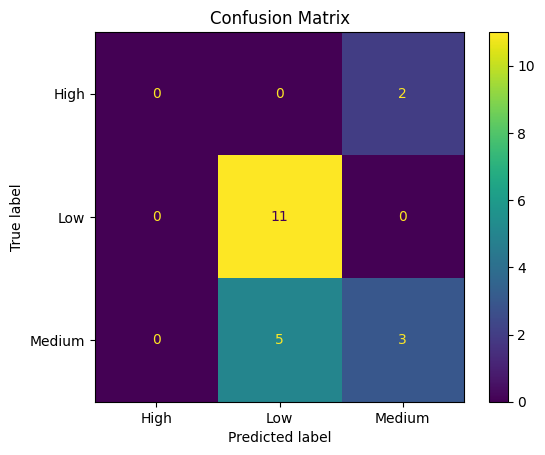


--- Top Features ---
               feature  importance
2  flesch_reading_ease    0.947301
0           word_count    0.381014
1       sentence_count    0.335054

Trained model pipeline saved to /kaggle/working/models/quality_model.pkl

--- Phase 4 Complete ---


In [ ]:
# Content Quality Scoring
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

print("\n--- Phase 4: Content Quality Scoring ---")

# Load Data & Create Labels
DATA_DIR = '/kaggle/working/data'
MODELS_DIR = '/kaggle/working/models'
FEATURES_CSV = os.path.join(DATA_DIR, 'features.csv')
MODEL_FILE = os.path.join(MODELS_DIR, 'quality_model.pkl')

if not os.path.exists(FEATURES_CSV):
    print(f"Error: File not found at {FEATURES_CSV}. Please run Phase 3 first.")
else:
    print("Loading features...")
    df_model = pd.read_csv(FEATURES_CSV)

    # Create synthetic labels based on the rules
    conditions = [
        (df_model['word_count'] > 1500) & (df_model['flesch_reading_ease'] >= 50) & (df_model['flesch_reading_ease'] <= 70), # High
        (df_model['word_count'] < 500) | (df_model['flesch_reading_ease'] < 30)  # Low
    ]
    choices = ['High', 'Low']
    df_model['quality_label'] = np.select(conditions, choices, default='Medium')
    
    print("Synthetic quality labels created:")
    print(df_model['quality_label'].value_counts(normalize=True))

    # Define Features (X) and Target (y) 
    feature_cols = ['word_count', 'sentence_count', 'flesch_reading_ease']
    X = df_model[feature_cols]
    y = df_model['quality_label']

    # Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
    print(f"Data split: {len(X_train)} train, {len(X_test)} test samples.")

    # Train Classification Model 
    # Use a Pipeline to combine scaling and modeling
    print("Training Logistic Regression model...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(multi_class='ovr', random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    
    # Evaluate Model
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print("\n--- Model Performance ---")
    print(f"Overall Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(report)
    
    # Plot Confusion Matrix
    print("Generating Confusion Matrix...")
    %matplotlib inline
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Report Top Features
    print("\n--- Top Features ---")
    try:
        model = pipeline.named_steps['model']
        # Average absolute coefficient across classes for importance
        importance = np.mean(np.abs(model.coef_), axis=0)
        feature_importance = pd.DataFrame({'feature': feature_cols, 'importance': importance})
        feature_importance = feature_importance.sort_values(by='importance', ascending=False)
        print(feature_importance.head(3))
    except Exception as e:
        print(f"Could not determine feature importance: {e}")

    # Save the Model 
    joblib.dump(pipeline, MODEL_FILE)
    print(f"\nTrained model pipeline saved to {MODEL_FILE}")
    print("\n--- Phase 4 Complete ---")

In [ ]:
# Real-Time Analysis Demo
import requests
from bs4 import BeautifulSoup
import nltk
import textstat
import re
import joblib
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json

print("\n--- Phase 5: Real-Time Analysis Demo ---")

# Load all assets one time 
print("Loading all assets (model, embeddings, SBERT)...")
DATA_DIR = '/kaggle/working/data'
MODELS_DIR = '/kaggle/working/models'

# Load the trained model pipeline
MODEL_FILE = os.path.join(MODELS_DIR, 'quality_model.pkl')
model_pipeline = joblib.load(MODEL_FILE)

# Load the corpus embeddings for duplicate checking
EMBEDDINGS_FILE = os.path.join(DATA_DIR, 'embeddings.npy')
corpus_embeddings = np.load(EMBEDDINGS_FILE)

# Load the URLs corresponding to the embeddings
FEATURES_CSV = os.path.join(DATA_DIR, 'features.csv')
df_corpus = pd.read_csv(FEATURES_CSV)
corpus_urls = df_corpus['url'].tolist()

# Initialize the SBERT model (will use T4 GPU)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
print("All assets loaded and ready.")

# Define the Real-Time Analysis Function 
def analyze_url(url):
    """
    Accepts a URL, scrapes it, extracts features, scores quality,
    and checks for duplicates against the corpus.
    """
    print(f"\nAnalyzing URL: {url}...")
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    # Scrape & Parse 
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Use the same parsing logic as Phase 1
        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.title.string if soup.title else 'No Title Found'
        content_tags = soup.find('article') or soup.find('main') or soup.find_all('p')
        if content_tags:
            if isinstance(content_tags, list):
                body_text = ' '.join([tag.get_text(separator=' ') for tag in content_tags])
            else:
                body_text = content_tags.get_text(separator=' ')
        else:
            body_text = soup.body.get_text(separator=' ') if soup.body else ''
        
        clean_text = re.sub(r'\s+', ' ', body_text).strip().lower()

    except requests.RequestException as e:
        print(f"Error scraping URL: {e}")
        return {"error": str(e)}
    except Exception as e:
        print(f"Error parsing content: {e}")
        return {"error": f"Error parsing content: {e}"}

    # Extract Features
    word_count = len(clean_text.split())
    if word_count == 0:
        return {"error": "Could not extract meaningful content."}
        
    sentence_count = len(nltk.sent_tokenize(clean_text))
    readability = textstat.flesch_reading_ease(clean_text)
    is_thin = word_count < 500
    
    # Predict Quality
    features_df = pd.DataFrame([[word_count, sentence_count, readability]], 
                               columns=['word_count', 'sentence_count', 'flesch_reading_ease'])
    quality_label = model_pipeline.predict(features_df)[0]
    
    #  Check for Duplicates (uses GPU)
    new_embedding = sbert_model.encode([clean_text])
    similarities = cosine_similarity(new_embedding, corpus_embeddings)[0]
    
    SIMILARITY_THRESHOLD = 0.80
    similar_to = []
    for i, score in enumerate(similarities):
        # Don't compare the page to itself if it's in the corpus
        if score > SIMILARITY_THRESHOLD and corpus_urls[i] != url:
            similar_to.append({
                "url": corpus_urls[i],
                "similarity": float(score)
            })
            
    similar_to = sorted(similar_to, key=lambda x: x['similarity'], reverse=True)

    #  Format Output
    result = {
        "url": url,
        "title": title,
        "word_count": word_count,
        "sentence_count": sentence_count,
        "readability": round(readability, 2),
        "quality_label": quality_label,
        "is_thin": is_thin,
        "similar_to": similar_to
    }
    
    print("Analysis complete.")
    return result

# Example Usage 
# Test with a stable, well-known URL
test_url = "https://en.wikipedia.org/wiki/Data_science" 
result = analyze_url(test_url)

# Print as formatted JSON
print("\n--- Analysis Result ---")
print(json.dumps(result, indent=2))
print("\n--- Phase 5 Complete ---")


--- Phase 5: Real-Time Analysis Demo ---
Loading all assets (model, embeddings, SBERT)...
All assets loaded and ready.

Analyzing URL: https://en.wikipedia.org/wiki/Data_science...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analysis complete.

--- Analysis Result ---
{
  "url": "https://en.wikipedia.org/wiki/Data_science",
  "title": "Data science - Wikipedia",
  "word_count": 2904,
  "sentence_count": 259,
  "readability": 32.88,
  "quality_label": "Low",
  "is_thin": false,
  "similar_to": [
    {
      "url": "https://en.wikipedia.org/wiki/Digital_marketing",
      "similarity": 0.8685389161109924
    },
    {
      "url": "https://simple.wikipedia.org/wiki/Digital_marketing",
      "similarity": 0.8504990339279175
    }
  ]
}

--- Phase 5 Complete ---


In [ ]:
# Generate requirements.txt
!pip freeze > /kaggle/working/requirements.txt
print("requirements.txt saved to /kaggle/working/requirements.txt")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


requirements.txt saved to /kaggle/working/requirements.txt


In [ ]:
# Create Streamlit App Structure
import os
import shutil

print("Creating Streamlit app directory structure...")

# 1. Define all paths
APP_DIR = '/kaggle/working/streamlit_app'
UTILS_DIR = os.path.join(APP_DIR, 'utils')
MODELS_DIR_APP = os.path.join(APP_DIR, 'models') # The app's model dir

# Source paths (where your files are now)
SRC_MODEL_FILE = '/kaggle/working/models/quality_model.pkl'
SRC_EMBEDDINGS_FILE = '/kaggle/working/data/embeddings.npy'
SRC_FEATURES_FILE = '/kaggle/working/data/features.csv'

# 2. Create directories
os.makedirs(APP_DIR, exist_ok=True)
os.makedirs(UTILS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR_APP, exist_ok=True)

# 3. Copy the essential files into the app's structure
# This is crucial for deployment!
try:
    shutil.copy(SRC_MODEL_FILE, MODELS_DIR_APP)
    shutil.copy(SRC_EMBEDDINGS_FILE, MODELS_DIR_APP)
    shutil.copy(SRC_FEATURES_FILE, MODELS_DIR_APP)
    print("Copied model, embeddings, and features to streamlit_app/models/")
except Exception as e:
    print(f"Error copying files: {e}")
    print("Please ensure Phase 2-4 ran successfully and created the files.")

print("Streamlit directory structure created.")

Creating Streamlit app directory structure...
Copied model, embeddings, and features to streamlit_app/models/
Streamlit directory structure created.


In [22]:
%%writefile /kaggle/working/streamlit_app/utils/parser.py
import re
from bs4 import BeautifulSoup
import requests

def scrape_and_parse(url):
    """
    Scrapes a URL and parses its content to extract
    title and clean body text.
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    # --- 1. Scrape ---
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error scraping URL: {e}")
        raise ValueError(f"Error scraping URL: {e}")

    # --- 2. Parse ---
    try:
        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.title.string if soup.title else 'No Title Found'
        
        content_tags = soup.find('article') or soup.find('main') or soup.find_all('p')
        if content_tags:
            if isinstance(content_tags, list):
                body_text = ' '.join([tag.get_text(separator=' ') for tag in content_tags])
            else:
                body_text = content_tags.get_text(separator=' ')
        else:
            body_text = soup.body.get_text(separator=' ') if soup.body else ''
        
        clean_text = re.sub(r'\s+', ' ', body_text).strip().lower()
        
        if not clean_text or len(clean_text.split()) == 0:
            raise ValueError("Could not extract meaningful content.")
            
        return title, clean_text

    except Exception as e:
        print(f"Error parsing content: {e}")
        raise ValueError(f"Error parsing content: {e}")

print("File 'streamlit_app/utils/parser.py' written.")

Writing /kaggle/working/streamlit_app/utils/parser.py


In [23]:
%%writefile /kaggle/working/streamlit_app/utils/features.py
import nltk
import textstat
import pandas as pd

# Download NLTK data (Streamlit Cloud needs this)
nltk.download('punkt', quiet=True)

def extract_features(clean_text):
    """
    Extracts word count, sentence count, readability, and thin content flag.
    """
    word_count = len(clean_text.split())
    sentence_count = len(nltk.sent_tokenize(clean_text))
    readability = textstat.flesch_reading_ease(clean_text)
    is_thin = word_count < 500
    
    # Create a DataFrame for the model
    features_df = pd.DataFrame([[word_count, sentence_count, readability]], 
                               columns=['word_count', 'sentence_count', 'flesch_reading_ease'])
    
    feature_dict = {
        "word_count": word_count,
        "sentence_count": sentence_count,
        "readability": round(readability, 2),
        "is_thin": is_thin
    }
    
    return features_df, feature_dict

print("File 'streamlit_app/utils/features.py' written.")

Writing /kaggle/working/streamlit_app/utils/features.py


In [24]:
%%writefile /kaggle/working/streamlit_app/utils/scorer.py
import joblib
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import os
import streamlit as st

# --- 1. Load All Models & Data ONCE ---
# Use @st.cache_resource to load models only once
# This is the key to a fast Streamlit app.

# Define paths relative to this file
# 'utils/' -> 'streamlit_app/' -> 'models/'
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
MODELS_DIR = os.path.join(BASE_DIR, 'models')

MODEL_FILE = os.path.join(MODELS_DIR, 'quality_model.pkl')
EMBEDDINGS_FILE = os.path.join(MODELS_DIR, 'embeddings.npy')
FEATURES_FILE = os.path.join(MODELS_DIR, 'features.csv')

@st.cache_resource
def load_model():
    """Loads the trained ML model."""
    try:
        return joblib.load(MODEL_FILE)
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None

@st.cache_resource
def load_sbert_model():
    """Loads the SentenceTransformer model."""
    try:
        return SentenceTransformer('all-MiniLM-L6-v2')
    except Exception as e:
        st.error(f"Error loading SBERT model: {e}")
        return None

@st.cache_data
def load_corpus_data():
    """Loads the corpus embeddings and features for duplicate checking."""
    try:
        corpus_embeddings = np.load(EMBEDDINGS_FILE)
        df_corpus = pd.read_csv(FEATURES_FILE)
        corpus_urls = df_corpus['url'].tolist()
        return corpus_embeddings, corpus_urls
    except Exception as e:
        st.error(f"Error loading corpus data: {e}")
        return None, None

# Load everything
model_pipeline = load_model()
sbert_model = load_sbert_model()
corpus_embeddings, corpus_urls = load_corpus_data()

# --- 2. Main Analysis Function ---

def predict_quality(features_df):
    """Predicts quality using the loaded model."""
    if model_pipeline is None:
        raise ValueError("Model not loaded.")
    
    try:
        quality_label = model_pipeline.predict(features_df)[0]
        return quality_label
    except Exception as e:
        raise ValueError(f"Error during prediction: {e}")

def check_for_duplicates(clean_text, url):
    """Checks for duplicates against the loaded corpus."""
    if sbert_model is None or corpus_embeddings is None:
        raise ValueError("Corpus or SBERT model not loaded.")
        
    try:
        new_embedding = sbert_model.encode([clean_text])
        similarities = cosine_similarity(new_embedding, corpus_embeddings)[0]
        
        SIMILARITY_THRESHOLD = 0.80
        similar_to = []
        for i, score in enumerate(similarities):
            # Don't compare the page to itself if it's in the corpus
            if score > SIMILARITY_THRESHOLD and corpus_urls[i] != url:
                similar_to.append({
                    "url": corpus_urls[i],
                    "similarity": float(score)
                })
        
        return sorted(similar_to, key=lambda x: x['similarity'], reverse=True)
        
    except Exception as e:
        raise ValueError(f"Error checking duplicates: {e}")

print("File 'streamlit_app/utils/scorer.py' written.")

Writing /kaggle/working/streamlit_app/utils/scorer.py


In [ ]:
%%writefile /kaggle/working/streamlit_app/app.py
import streamlit as st
import json
from utils.parser import scrape_and_parse
from utils.features import extract_features
from utils.scorer import predict_quality, check_for_duplicates

# App Title and Description
st.set_page_config(page_title="SEO Content Analyzer", layout="wide")
st.title("🤖 SEO Content Quality & Duplicate Detector")
st.markdown("""
This app analyzes a live URL to assess its SEO quality and check for near-duplicates 
against a pre-computed corpus. This is a demo for the LeadWalnut/CodeWalnut assignment.
""")

# URL Input 
url = st.text_input("Enter a URL to analyze:", placeholder="https://example.com/blog-post")

# Analyze Button
if st.button("Analyze Content", type="primary"):
    if not url:
        st.warning("Please enter a URL to analyze.")
    else:
        try:
            # Analysis Pipeline 
            with st.spinner("Analyzing... This may take a moment..."):
                
                # Scrape and Parse
                st.subheader("1. Parsing Content")
                title, clean_text = scrape_and_parse(url)
                st.success(f"Successfully scraped and parsed content.")
                st.text(f"Page Title: {title}")

                #  Extract Features
                st.subheader("2. Extracting Features")
                features_df, feature_dict = extract_features(clean_text)
                st.success("Features extracted.")
                
                cols = st.columns(3)
                cols[0].metric("Word Count", feature_dict['word_count'])
                cols[1].metric("Sentence Count", feature_dict['sentence_count'])
                cols[2].metric("Readability (Flesch)", f"{feature_dict['readability']:.2f}")

                #  Predict Quality
                st.subheader("3. Scoring Quality")
                quality_label = predict_quality(features_df)
                st.success("Content quality scored.")
                
                if quality_label == "High":
                    st.markdown(f"**Predicted Quality: <span style='color:green; font-weight:bold;'>{quality_label}</span>**", unsafe_allow_html=True)
                elif quality_label == "Medium":
                    st.markdown(f"**Predicted Quality: <span style='color:orange; font-weight:bold;'>{quality_label}</span>**", unsafe_allow_html=True)
                else:
                    st.markdown(f"**Predicted Quality: <span style='color:red; font-weight:bold;'>{quality_label}</span>**", unsafe_allow_html=True)
                
                st.info(f"Thin Content (< 500 words): **{feature_dict['is_thin']}**")

                #  Check Duplicates
                st.subheader("4. Checking for Duplicates")
                similar_to = check_for_duplicates(clean_text, url)
                st.success("Duplicate check complete.")
                
                if not similar_to:
                    st.info("No near-duplicates found in the corpus (similarity > 80%).")
                else:
                    st.warning(f"Found {len(similar_to)} similar page(s):")
                    for item in similar_to:
                        st.markdown(f"- **URL:** `{item['url']}` \n - **Similarity:** `{item['similarity']:.2%}`")

                #  Show Full Result
                st.subheader("5. Full Analysis Result (JSON)")
                result = {
                    "url": url,
                    "title": title,
                    "quality_label": quality_label,
                    **feature_dict,
                    "similar_to": similar_to
                }
                st.json(json.dumps(result, indent=2))

        except Exception as e:
            st.error(f"An error occurred during analysis: {e}")

print("File 'streamlit_app/app.py' written.")

Writing /kaggle/working/streamlit_app/app.py


In [26]:
%%writefile /kaggle/working/streamlit_app/requirements.txt
streamlit
pandas
scikit-learn
nltk
textstat
sentence-transformers
requests
beautifulsoup4
joblib

print("File 'streamlit_app/requirements.txt' written.")

Writing /kaggle/working/streamlit_app/requirements.txt
